In [1]:
#With assistance from https://learnopencv.com/image-classification-using-transfer-learning-in-pytorch/

import torch, torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import time
from torchsummary import summary

import numpy as np
import matplotlib.pyplot as plt
import os

from PIL import Image

In [2]:
# Transforming the images
image_transforms = { 
    'train': transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.450, 0.450, 0.450],[0.220, 0.220, 0.220])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.450, 0.450, 0.450],[0.220, 0.220, 0.220])
    ]),
    'test': transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.450, 0.450, 0.450],[0.220, 0.220, 0.220])
    ])
}

In [3]:
# Load in the shark images from a folder

# Set train, valid, and test directory paths

dataset = 'FULL Shark Data'

train_directory = os.path.join(dataset, 'train')
valid_directory = os.path.join(dataset, 'valid')
test_directory = os.path.join(dataset, 'test')

# Batch size
bs = 32

# Prints the number of classes in this dataset
num_classes = len(os.listdir(valid_directory))
print(num_classes)

# Load Data from folders
data = {
    'train': datasets.ImageFolder(root=train_directory, transform=image_transforms['train']),
    'valid': datasets.ImageFolder(root=valid_directory, transform=image_transforms['valid']),
    'test': datasets.ImageFolder(root=test_directory, transform=image_transforms['test'])
}

# Get the indices to the class names, print the indeces and the class names.
idx_to_class = {v: k for k, v in data['train'].class_to_idx.items()}
print(idx_to_class)

# Find the Size of each dataset
train_data_size = len(data['train'])
valid_data_size = len(data['valid'])
test_data_size = len(data['test'])

# Iterators for each of the three datasets
train_data_loader = DataLoader(data['train'], batch_size=bs, shuffle=True)
valid_data_loader = DataLoader(data['valid'], batch_size=bs, shuffle=True)
test_data_loader = DataLoader(data['test'], batch_size=bs, shuffle=True)

4
{0: 'hammerhead shark', 1: 'oceanic whitetip shark', 2: 'silvertip shark', 3: 'tiger shark'}


In [4]:
#Set the device and print the size of each dataset category
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(train_data_size, valid_data_size, test_data_size)

240 40 121


In [6]:
# Load pretrained ResNet50 Model
resnet50 = models.resnet50(pretrained=True)
resnet50 = resnet50.to(device)

In [7]:
# Freeze the model in preparation for training
for param in resnet50.parameters():
    param.requires_grad = False

In [8]:
# Change the final layer of ResNet50 Model for Transfer Learning
fc_inputs = resnet50.fc.in_features

resnet50.fc = nn.Sequential(
    nn.Linear(fc_inputs, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, num_classes),
    nn.LogSoftmax(dim=1)
)
# Convert model to be used on GPU
resnet50 = resnet50.to(device)

In [9]:
# Initiate the loss function and optimizer
loss_func = nn.NLLLoss()
optimizer = optim.Adam(resnet50.parameters())

In [10]:
#Helper Function
#Used to train and validate the model

def train_and_validate(model, loss_criterion, optimizer, epochs=30):
    start = time.time()
    history = []
    best_loss = 100000.0
    best_epoch = None

    for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))
        
        # Set to training mode
        model.train()
        
        # Loss and Accuracy within the epoch
        train_loss = 0.0
        train_acc = 0.0
        
        valid_loss = 0.0
        valid_acc = 0.0
        
        for i, (inputs, labels) in enumerate(train_data_loader):

            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # refresh the optimizer
            optimizer.zero_grad()
            
            # find the outputs of the input data
            outputs = model(inputs)
            
            # gather the Loss data
            loss = loss_criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            # total loss added onto the training loss
            train_loss += loss.item() * inputs.size(0)
            
            # gather the accuracy data
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            
            # change typing to Float, find the mean using the float values
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            
            # total accuracy added onto the training accuracy
            train_acc += acc.item() * inputs.size(0)
        
        # Loops for Validation dataset
        with torch.no_grad():

            # model = evaluation / validation mode
            model.eval()

            # Loop for validation
            for j, (inputs, labels) in enumerate(valid_data_loader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # find the outputs of the input data
                outputs = model(inputs)

                # gather the Loss data
                loss = loss_criterion(outputs, labels)

                # total loss added onto the training loss
                valid_loss += loss.item() * inputs.size(0)

                # gather the accuracy data
                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))

                # change typing to Float, find the mean using the float values
                acc = torch.mean(correct_counts.type(torch.FloatTensor))

                # total accuracy added onto the validation accuracy
                valid_acc += acc.item() * inputs.size(0)

        if valid_loss < best_loss:
            best_loss = valid_loss
            best_epoch = epoch

        # calculate the averages
        avg_train_loss = train_loss/train_data_size 
        avg_train_acc = train_acc/train_data_size

        # calculate the averages
        avg_valid_loss = valid_loss/valid_data_size 
        avg_valid_acc = valid_acc/valid_data_size

        history.append([avg_train_loss, avg_valid_loss, avg_train_acc, avg_valid_acc])
                
        epoch_end = time.time()

        #Set the print output for each epoch
        print("Epoch : {:03d}, Training: Loss - {:.4f}, Accuracy - {:.4f}%, \n\t\tValidation : Loss - {:.4f}, Accuracy - {:.4f}%, Time: {:.4f}s".format(epoch, avg_train_loss, avg_train_acc*100, avg_valid_loss, avg_valid_acc*100, epoch_end-epoch_start))
        
        # Save if the model has best accuracy till now
        torch.save(model, dataset+'_model_SharkByteFULL_'+str(epoch)+'.pt')
            
    return model, history, best_epoch

In [11]:
# Train the model for 30 epochs
num_epochs = 30
trained_model, history, best_epoch = train_and_validate(resnet50, loss_func, optimizer, num_epochs)

torch.save(history, dataset+'_SharkByteFULL_history.pt')

Epoch: 1/30
Epoch : 000, Training: Loss - 1.2790, Accuracy - 40.8333%, 
		Validation : Loss - 0.9587, Accuracy - 72.5000%, Time: 13.6794s
Epoch: 2/30
Epoch : 001, Training: Loss - 0.9189, Accuracy - 66.6667%, 
		Validation : Loss - 0.7269, Accuracy - 72.5000%, Time: 7.9046s
Epoch: 3/30
Epoch : 002, Training: Loss - 0.7432, Accuracy - 70.4167%, 
		Validation : Loss - 0.6407, Accuracy - 72.5000%, Time: 7.6471s
Epoch: 4/30
Epoch : 003, Training: Loss - 0.5601, Accuracy - 81.2500%, 
		Validation : Loss - 0.6724, Accuracy - 75.0000%, Time: 7.5821s
Epoch: 5/30
Epoch : 004, Training: Loss - 0.5861, Accuracy - 76.6667%, 
		Validation : Loss - 0.6272, Accuracy - 72.5000%, Time: 7.6545s
Epoch: 6/30
Epoch : 005, Training: Loss - 0.4871, Accuracy - 82.5000%, 
		Validation : Loss - 0.5361, Accuracy - 75.0000%, Time: 7.5346s
Epoch: 7/30
Epoch : 006, Training: Loss - 0.4260, Accuracy - 82.5000%, 
		Validation : Loss - 0.6332, Accuracy - 70.0000%, Time: 7.5492s
Epoch: 8/30
Epoch : 007, Training: Loss 

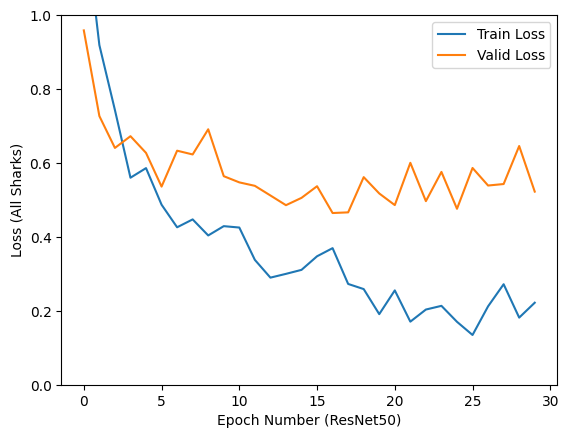

In [12]:
history = np.array(history)
plt.plot(history[:,0:2])
plt.legend(['Train Loss', 'Valid Loss'])
plt.xlabel('Epoch Number (ResNet50)')
plt.ylabel('Loss (All Sharks)')
plt.ylim(0,1)
plt.savefig(dataset+'_loss_curve_SharkByteFULL.png')
plt.show()

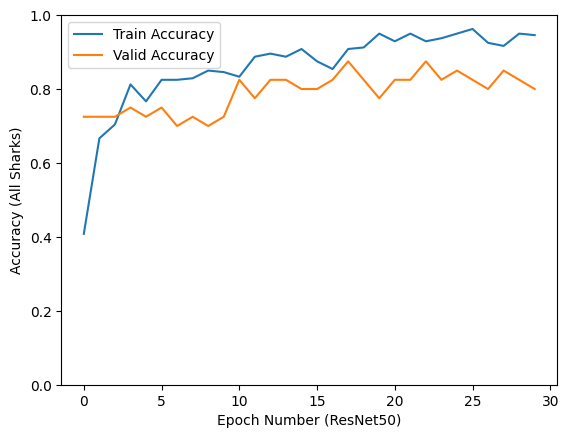

In [13]:
plt.plot(history[:,2:4])
plt.legend(['Train Accuracy', 'Valid Accuracy'])
plt.xlabel('Epoch Number (ResNet50)')
plt.ylabel('Accuracy (All Sharks)')
plt.ylim(0,1)
plt.savefig(dataset+'_accuracy_curve_SharkByteFULL.png')
plt.show()

In [18]:
#Helper Function
#Used to find the prediction accuracy using the entire test set of images

def testDatasetAcc(model, loss_criterion):
    #set the device to compute with
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    test_acc = 0.0
    test_loss = 0.0

    with torch.no_grad():

        # model = evaluation mode
        model.eval()

        # Loop for test set
        for j, (inputs, labels) in enumerate(test_data_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # find the outputs of the input data
            outputs = model(inputs)

            # gather the Loss data
            loss = loss_criterion(outputs, labels)

            # total loss added onto the training loss
            test_loss += loss.item() * inputs.size(0)

            # gather the accuracy data
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))

            # change typing to Float, find the mean using the float values
            acc = torch.mean(correct_counts.type(torch.FloatTensor))

            # total accuracy added onto the validation accuracy
            test_acc += acc.item() * inputs.size(0)

            #Print the output of the test
            print("Test Batch number: {:03d}, Test: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))

    # calculate the averages
    avg_test_loss = test_loss/test_data_size 
    avg_test_acc = test_acc/test_data_size

    #Print the output of the accuracy
    print("Test accuracy : " + str(avg_test_acc))
    print("Test Loss : " + str(avg_test_loss))

In [19]:
#Helper Function
#Used to predict one single image using the model

def soloPredict(model, test_image_name):
    transform = image_transforms['test']


    test_image = Image.open(test_image_name)
    plt.imshow(test_image)
    
    test_image_tensor = transform(test_image)
    if torch.cuda.is_available():
        test_image_tensor = test_image_tensor.view(1, 3, 224, 224).cuda()
    else:
        test_image_tensor = test_image_tensor.view(1, 3, 224, 224)
    
    with torch.no_grad():
        model.eval()
        out = model(test_image_tensor)
        ps = torch.exp(out)

        topk, topclass = ps.topk(2, dim=1)
        cls = idx_to_class[topclass.cpu().numpy()[0][0]]
        score = topk.cpu().numpy()[0][0]

        # print out the prediction
        for i in range(2):
            print("Predcition", i+1, ":", idx_to_class[topclass.cpu().numpy()[0][i]], ", Score: ", topk.cpu().numpy()[0][i])

Predcition 1 : silvertip shark , Score:  0.82083696
Predcition 2 : oceanic whitetip shark , Score:  0.15592311


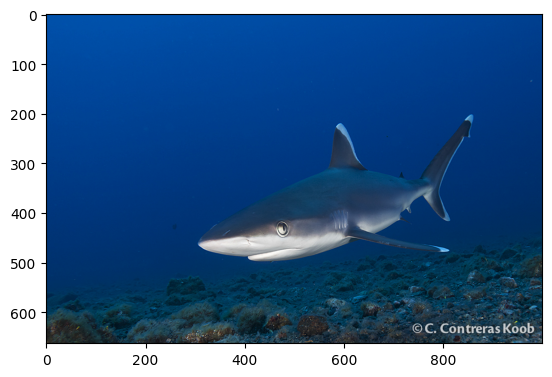

In [20]:
# Test a specific image on the model
dataset = 'FULL Shark Data'
model = torch.load("{}_model_SharkByteFULL_{}.pt".format(dataset, best_epoch))
soloPredict(model, "FULL Shark Data/test/silvertip shark/0077.jpg")

In [21]:
#Test the whole test set of images on the model
img = testDatasetAcc(model, loss_func)

Test Batch number: 000, Test: Loss: 0.3883, Accuracy: 0.9062
Test Batch number: 001, Test: Loss: 0.4131, Accuracy: 0.8125
Test Batch number: 002, Test: Loss: 0.5000, Accuracy: 0.8750
Test Batch number: 003, Test: Loss: 0.4906, Accuracy: 0.8000
Test accuracy : 0.8512396718844895
Test Loss : 0.44552692844848
